In [1]:
from clustering import *
from downloaddata import *
from portfolio_and_performance import *
from trees import *
import cPickle as pickle
import matlab.engine

In [2]:
def exponential_weighted_corr(rdata, t, theta=250, window=250):
    """
    Compared to the formula in paper, tou is the length of time window, so use window to stand
        for tou
    t is the date of correlation(number in the list)
    
    """
    weight_list = [np.exp((i - window) / theta) for i in range(1, window + 1)]
    weight_list = np.array(weight_list / sum(weight_list))
    t_list = rdata.index.format()

    end = t_list.index(t)
    start = end - window + 1
    startdate = rdata.index[start]
    enddate = rdata.index[end]

    tmp = rdata.loc[startdate:enddate]

    cov = np.cov(tmp.values, rowvar=False, aweights=weight_list)
    cov_diag = np.sqrt(np.diag(cov))
    corr = (cov / cov_diag).T / cov_diag
    # corr = pd.DataFrame(corr, index = )
    return corr


def rolling_expweighted_corr(rdata, t, theta=250, window=250):
    dic0 = {}
    # for i in range(window-1, len(rdata.index)):
    t_list = rdata.index.format()
    for i in range(t - window, t + 1):
        date = t_list[i]
        dic0[date] = pd.DataFrame(exponential_weighted_corr(rdata, date, theta, window), index= \
            rdata.columns, columns=rdata.columns)
    return dic0


def shrinkage(t, log_ret, theta=250, window=250):
    dates = sorted(log_ret.index)
    dates = [str(x)[:10] for x in dates]
    # dic0 is a dictionary. Keys are dates; values are the exponential-weighted pearson correlation matrixs for a 250-day window ending at that date.
    t_index = dates.index(t)
    dic0 = rolling_expweighted_corr(log_ret, t_index, theta, window)
    # create an empty dataframe to calculate the first part in the formula
    new = pd.DataFrame(0, columns=log_ret.columns, index=log_ret.columns)
    # create an zero number to calculate the second part in the formula
    num = 0

    # window = 125, for the shrinkage correlation at time t, we need the exponential-weighted pearson correlation coefficient over the last tou days
    for i in range(dates.index(t) - window, dates.index(t) + 1):
        d = dates[i]
        # the first part of the formula: sum of the correlation coefficent of the two specific stocks during the 125 days 
        a = dic0[d]
        a = a.dropna(axis=0, how='all')
        a = a.dropna(axis=1, how='all')
        new += a
        # the second part of the formula: sum of the correlation coefficent of all pairs of stocks during the 125 days 
        num += (sum(a.sum()) - log_ret.shape[1]) / 2
        # normalization corresponding to the formular (2/(N*(N-1)))
    num = num * 2 / ((log_ret.shape[1]) * (log_ret.shape[1] - 1))
    new = new.dropna(axis=0, how='all')
    new = new.dropna(axis=1, how='all')
    new = new + num
    # normalization corresponding to the formular (2/(window+1))
    new = new / (window + 1)
    return new

In [3]:
price = importdata("data/WRDS/SP500_price_1985.csv").replace(0,np.nan).ffill()
ret = importdata("data/WRDS/SP500_ret_1985.csv").fillna(0)
div = importdata("data/WRDS/SP500_div_1985.csv").fillna(0)
cpr = importdata("data/WRDS/SP500_cpr_1985.csv").replace(0,np.nan).ffill()

In [107]:
logret = np.log(price) - np.log(price.shift(1))
logret = logret.iloc[1:]

In [6]:
dic0 = rolling_expweighted_corr(logret, t=200, window=20)

In [7]:
eng = matlab.engine.start_matlab()
eng.cd(r'MATLAB')

{'1984-09-18':           10145     10516     11308     11404     11674     11703     11762  \
 10145  1.000000  0.577561  0.592646  0.471295  0.046223  0.676740  0.336115   
 10516  0.577561  1.000000  0.496675  0.546911 -0.303357  0.471970  0.191004   
 11308  0.592646  0.496675  1.000000  0.700931  0.142312  0.839693  0.530254   
 11404  0.471295  0.546911  0.700931  1.000000 -0.051126  0.629198  0.491508   
 11674  0.046223 -0.303357  0.142312 -0.051126  1.000000  0.026650 -0.018718   
 11703  0.676740  0.471970  0.839693  0.629198  0.026650  1.000000  0.458719   
 11762  0.336115  0.191004  0.530254  0.491508 -0.018718  0.458719  1.000000   
 11850  0.249124  0.530957  0.437102  0.464401 -0.071911  0.306348 -0.107828   
 12052  0.573192  0.593819  0.692974  0.511557  0.081466  0.702225  0.339666   
 12060  0.420621  0.623484  0.645131  0.558764 -0.197548  0.541667  0.572946   
 12431  0.519126  0.257977  0.257643  0.320586 -0.210655  0.345047  0.242969   
 12490  0.601990  0.748512

In [243]:
A = exponential_weighted_corr(ret, '2000-01-03', 1000/3, 1000)
np.fill_diagonal(A, 1)
D = (2 * (1 - A)) ** 0.5
S = A + 1
D = matlab.double(D.tolist())
S = matlab.double(S.tolist())

In [245]:
T8, Rpm, Adjv, Dpm, Mv, Z = eng.DBHTs(D, S, nargout=6)

In [246]:
np.array(S).min()

0.86933460172304733

In [247]:
max(np.array(T8))

array([ 8.])

In [4]:
def DBHT(thresh, filename="SP100_prices.csv", window=250, enddate="2017-01-24", startdate='2015-12-30', space=1,
         shrinkage="None"):
    """Returns a dictionary of Minimum Spanning Tree for each end date,
    space means the interval between two sample updates"""
    ret = importdata(filename)
    dic = rolling_corr(ret, thresh, window, enddate, startdate, space, shrinkage=shrinkage)
    clusterings = {}
    PMFG = {}
    bubble_cluster_membership = {}
    PMFG_shortest_path_length_matrix = {}
    bubble_membership_mattrix = {}
    DBHT_hierarchy = {}
    eng = matlab.engine.start_matlab()
    eng.cd(r'MATLAB')
    count = 0
    for key in sorted(dic.keys()):
        count+=1
        D = dic[key]
        S = 2-(D**2/2)
        D = matlab.double(D.as_matrix().tolist())
        S = matlab.double(S.as_matrix().tolist())
        T8, Rpm, Adjv, Dpm, Mv, Z = eng.DBHTs(D, S, nargout=6)
        clusterings[key] = T8
        PMFG[key] = Rpm
        bubble_cluster_membership[key] = Adjv
        PMFG_shortest_path_length_matrix[key] = Dpm
        bubble_membership_mattrix[key] = Mv
        DBHT_hierarchy[key] = Z
        print "building DBHT for the number "+ str(count) + " date " + key + " done."
    return {'DBHT_clusterings': clusterings, 'PMFG': PMFG,
            'bubble_cluster_membership_matrix': bubble_membership_mattrix,
            'PMFG_shortest_paath_length_matrix': PMFG_shortest_path_length_matrix,
            'bubble_membership_matrix': bubble_membership_mattrix,
            'DBHT_hierarchy': DBHT_hierarchy}

In [240]:
dic = rolling_expweighted_corr(ret, t=5000, theta=1000/3, window=1000)

In [241]:
dic.keys()

['2003-06-20',
 '2003-06-23',
 '2003-06-25',
 '2003-06-24',
 '2003-06-27',
 '2002-11-29',
 '2002-06-19',
 '2002-04-17',
 '2002-06-11',
 '2002-06-10',
 '2002-06-13',
 '2002-06-12',
 '2002-06-14',
 '2002-06-17',
 '2003-07-30',
 '2003-07-08',
 '2000-06-19',
 '2001-06-29',
 '2001-08-30',
 '2001-08-31',
 '2000-06-13',
 '2000-06-12',
 '2001-06-28',
 '2000-06-16',
 '2000-06-15',
 '2000-06-14',
 '2001-06-27',
 '2003-03-18',
 '2001-03-15',
 '2001-01-12',
 '2001-01-11',
 '2001-01-10',
 '2001-01-17',
 '2001-01-16',
 '2001-03-13',
 '2001-03-12',
 '2002-09-10',
 '2002-09-11',
 '2001-01-19',
 '2001-01-18',
 '2001-03-19',
 '2003-09-18',
 '2002-09-16',
 '2002-09-17',
 '2000-11-08',
 '2000-11-09',
 '2000-11-01',
 '2000-11-02',
 '2000-11-03',
 '2000-11-06',
 '2000-11-07',
 '2003-07-28',
 '2002-06-18',
 '2003-03-20',
 '2002-03-01',
 '2002-05-15',
 '2002-05-16',
 '2002-05-17',
 '2002-03-05',
 '2002-03-04',
 '2002-03-07',
 '2002-03-06',
 '2002-03-08',
 '2002-06-25',
 '2003-03-27',
 '2002-12-27',
 '2001-12-

In [ ]:
dic0 = rolling_expweighted_corr(ret, window=20)

In [5]:
def DBHT_exp_shrinkage(filename="SP100_prices.csv", window=250,space = 10):
    """Returns a dictionary of Minimum Spanning Tree for each end date,
    space means the interval between two sample updates"""
    ret = importdata(filename).fillna(0)
    clusterings = {}
    PMFG = {}
    bubble_cluster_membership = {}
    PMFG_shortest_path_length_matrix = {}
    bubble_membership_mattrix = {}
    DBHT_hierarchy = {}
    eng = matlab.engine.start_matlab()
    eng.cd(r'MATLAB')
    count = 0
    sorteddates = sorted([t.date().strftime("%Y-%m-%d") for t in ret.index])
    sorteddates = sorteddates[window::space]
    for key in sorteddates:
        count += 1
        A = exponential_weighted_corr(ret, key, window/3, window)
        np.fill_diagonal(A, 1)
        D = (2 * (1 - A)) ** 0.5
        S = A + 1
        D = matlab.double(D.tolist())
        S = matlab.double(S.tolist())
        T8, Rpm, Adjv, Dpm, Mv, Z = eng.DBHTs(D, S, nargout=6)
        clusterings[key] = T8
        PMFG[key] = Rpm
        bubble_cluster_membership[key] = Adjv
        PMFG_shortest_path_length_matrix[key] = Dpm
        bubble_membership_mattrix[key] = Mv
        DBHT_hierarchy[key] = Z
        print "building DBHT for the number " + str(count) + " date " + key + " done."
    return {'DBHT_clusterings': clusterings, 'PMFG': PMFG,
            'bubble_cluster_membership_matrix': bubble_membership_mattrix,
            'PMFG_shortest_paath_length_matrix': PMFG_shortest_path_length_matrix,
            'bubble_membership_matrix': bubble_membership_mattrix,
            'DBHT_hierarchy': DBHT_hierarchy}

In [24]:
DBHT_results = DBHT(thresh=95, filename = "data/WRDS/SP500_ret_1985.csv", window=1000,
     enddate='2016-12-30', startdate='1990-05-02',space=80, shrinkage='None')

In [298]:
DBHT_exp_shrinkage_results = DBHT_exp_shrinkage(filename="data/WRDS/SP500_ret_1985.csv", window=1000, space=20)

building DBHT for the number 1 date 1987-12-16 done.


building DBHT for the number 2 date 1988-01-15 done.


building DBHT for the number 3 date 1988-02-12 done.


building DBHT for the number 4 date 1988-03-14 done.


building DBHT for the number 5 date 1988-04-12 done.


building DBHT for the number 6 date 1988-05-10 done.


building DBHT for the number 7 date 1988-06-08 done.


building DBHT for the number 8 date 1988-07-07 done.


building DBHT for the number 9 date 1988-08-04 done.


building DBHT for the number 10 date 1988-09-01 done.


building DBHT for the number 11 date 1988-09-30 done.


building DBHT for the number 12 date 1988-10-28 done.


building DBHT for the number 13 date 1988-11-28 done.


building DBHT for the number 14 date 1988-12-27 done.


building DBHT for the number 15 date 1989-01-25 done.


building DBHT for the number 16 date 1989-02-23 done.


building DBHT for the number 17 date 1989-03-23 done.


building DBHT for the number 18 date 1989-04-21 done.


building DBHT for the number 19 date 1989-05-19 done.


building DBHT for the number 20 date 1989-06-19 done.


building DBHT for the number 21 date 1989-07-18 done.


building DBHT for the number 22 date 1989-08-15 done.


building DBHT for the number 23 date 1989-09-13 done.


building DBHT for the number 24 date 1989-10-11 done.


building DBHT for the number 25 date 1989-11-08 done.


building DBHT for the number 26 date 1989-12-07 done.


building DBHT for the number 27 date 1990-01-08 done.


building DBHT for the number 28 date 1990-02-05 done.


building DBHT for the number 29 date 1990-03-06 done.


building DBHT for the number 30 date 1990-04-03 done.


building DBHT for the number 31 date 1990-05-02 done.


building DBHT for the number 32 date 1990-05-31 done.


building DBHT for the number 33 date 1990-06-28 done.


building DBHT for the number 34 date 1990-07-27 done.


building DBHT for the number 35 date 1990-08-24 done.


building DBHT for the number 36 date 1990-09-24 done.


building DBHT for the number 37 date 1990-10-22 done.


building DBHT for the number 38 date 1990-11-19 done.


building DBHT for the number 39 date 1990-12-18 done.


building DBHT for the number 40 date 1991-01-17 done.


building DBHT for the number 41 date 1991-02-14 done.


building DBHT for the number 42 date 1991-03-15 done.


building DBHT for the number 43 date 1991-04-15 done.


building DBHT for the number 44 date 1991-05-13 done.


building DBHT for the number 45 date 1991-06-11 done.


building DBHT for the number 46 date 1991-07-10 done.


building DBHT for the number 47 date 1991-08-07 done.


building DBHT for the number 48 date 1991-09-05 done.


building DBHT for the number 49 date 1991-10-03 done.


building DBHT for the number 50 date 1991-10-31 done.


building DBHT for the number 51 date 1991-11-29 done.


building DBHT for the number 52 date 1991-12-30 done.


building DBHT for the number 53 date 1992-01-28 done.


building DBHT for the number 54 date 1992-02-26 done.


building DBHT for the number 55 date 1992-03-25 done.


building DBHT for the number 56 date 1992-04-23 done.


building DBHT for the number 57 date 1992-05-21 done.


building DBHT for the number 58 date 1992-06-19 done.


building DBHT for the number 59 date 1992-07-20 done.


building DBHT for the number 60 date 1992-08-17 done.


building DBHT for the number 61 date 1992-09-15 done.


building DBHT for the number 62 date 1992-10-13 done.


building DBHT for the number 63 date 1992-11-10 done.


building DBHT for the number 64 date 1992-12-09 done.


building DBHT for the number 65 date 1993-01-08 done.


building DBHT for the number 66 date 1993-02-05 done.


building DBHT for the number 67 date 1993-03-08 done.


building DBHT for the number 68 date 1993-04-05 done.


building DBHT for the number 69 date 1993-05-04 done.


building DBHT for the number 70 date 1993-06-02 done.


building DBHT for the number 71 date 1993-06-30 done.


building DBHT for the number 72 date 1993-07-29 done.


building DBHT for the number 73 date 1993-08-26 done.


building DBHT for the number 74 date 1993-09-24 done.


building DBHT for the number 75 date 1993-10-22 done.


building DBHT for the number 76 date 1993-11-19 done.


building DBHT for the number 77 date 1993-12-20 done.


building DBHT for the number 78 date 1994-01-18 done.


building DBHT for the number 79 date 1994-02-15 done.


building DBHT for the number 80 date 1994-03-16 done.


building DBHT for the number 81 date 1994-04-14 done.


building DBHT for the number 82 date 1994-05-13 done.


building DBHT for the number 83 date 1994-06-13 done.


building DBHT for the number 84 date 1994-07-12 done.


building DBHT for the number 85 date 1994-08-09 done.


building DBHT for the number 86 date 1994-09-07 done.


building DBHT for the number 87 date 1994-10-05 done.


building DBHT for the number 88 date 1994-11-02 done.


building DBHT for the number 89 date 1994-12-01 done.


building DBHT for the number 90 date 1994-12-30 done.


building DBHT for the number 91 date 1995-01-30 done.


building DBHT for the number 92 date 1995-02-28 done.


building DBHT for the number 93 date 1995-03-28 done.


building DBHT for the number 94 date 1995-04-26 done.


building DBHT for the number 95 date 1995-05-24 done.


building DBHT for the number 96 date 1995-06-22 done.


building DBHT for the number 97 date 1995-07-21 done.


building DBHT for the number 98 date 1995-08-18 done.


building DBHT for the number 99 date 1995-09-18 done.


building DBHT for the number 100 date 1995-10-16 done.


building DBHT for the number 101 date 1995-11-13 done.


building DBHT for the number 102 date 1995-12-12 done.


building DBHT for the number 103 date 1996-01-11 done.


building DBHT for the number 104 date 1996-02-08 done.


building DBHT for the number 105 date 1996-03-08 done.


building DBHT for the number 106 date 1996-04-08 done.


building DBHT for the number 107 date 1996-05-06 done.


building DBHT for the number 108 date 1996-06-04 done.


building DBHT for the number 109 date 1996-07-02 done.


building DBHT for the number 110 date 1996-07-31 done.


building DBHT for the number 111 date 1996-08-28 done.


building DBHT for the number 112 date 1996-09-26 done.


building DBHT for the number 113 date 1996-10-24 done.


building DBHT for the number 114 date 1996-11-21 done.


building DBHT for the number 115 date 1996-12-20 done.


building DBHT for the number 116 date 1997-01-21 done.


building DBHT for the number 117 date 1997-02-19 done.


building DBHT for the number 118 date 1997-03-19 done.


building DBHT for the number 119 date 1997-04-17 done.


building DBHT for the number 120 date 1997-05-15 done.


building DBHT for the number 121 date 1997-06-13 done.


building DBHT for the number 122 date 1997-07-14 done.


building DBHT for the number 123 date 1997-08-11 done.


building DBHT for the number 124 date 1997-09-09 done.


building DBHT for the number 125 date 1997-10-07 done.


building DBHT for the number 126 date 1997-11-04 done.


building DBHT for the number 127 date 1997-12-03 done.


building DBHT for the number 128 date 1998-01-02 done.


building DBHT for the number 129 date 1998-02-02 done.


building DBHT for the number 130 date 1998-03-03 done.


building DBHT for the number 131 date 1998-03-31 done.


building DBHT for the number 132 date 1998-04-29 done.


building DBHT for the number 133 date 1998-05-28 done.


building DBHT for the number 134 date 1998-06-25 done.


building DBHT for the number 135 date 1998-07-24 done.


building DBHT for the number 136 date 1998-08-21 done.


building DBHT for the number 137 date 1998-09-21 done.


building DBHT for the number 138 date 1998-10-19 done.


building DBHT for the number 139 date 1998-11-16 done.


building DBHT for the number 140 date 1998-12-15 done.


building DBHT for the number 141 date 1999-01-14 done.


building DBHT for the number 142 date 1999-02-12 done.


building DBHT for the number 143 date 1999-03-15 done.


building DBHT for the number 144 date 1999-04-13 done.


building DBHT for the number 145 date 1999-05-11 done.


building DBHT for the number 146 date 1999-06-09 done.


building DBHT for the number 147 date 1999-07-08 done.


building DBHT for the number 148 date 1999-08-05 done.


building DBHT for the number 149 date 1999-09-02 done.


building DBHT for the number 150 date 1999-10-01 done.


building DBHT for the number 151 date 1999-10-29 done.


building DBHT for the number 152 date 1999-11-29 done.


building DBHT for the number 153 date 1999-12-28 done.


building DBHT for the number 154 date 2000-01-26 done.


building DBHT for the number 155 date 2000-02-24 done.


building DBHT for the number 156 date 2000-03-23 done.


building DBHT for the number 157 date 2000-04-20 done.


building DBHT for the number 158 date 2000-05-19 done.


building DBHT for the number 159 date 2000-06-19 done.


building DBHT for the number 160 date 2000-07-18 done.


building DBHT for the number 161 date 2000-08-15 done.


building DBHT for the number 162 date 2000-09-13 done.


building DBHT for the number 163 date 2000-10-11 done.


building DBHT for the number 164 date 2000-11-08 done.


building DBHT for the number 165 date 2000-12-07 done.


building DBHT for the number 166 date 2001-01-08 done.


building DBHT for the number 167 date 2001-02-06 done.


building DBHT for the number 168 date 2001-03-07 done.


building DBHT for the number 169 date 2001-04-04 done.


building DBHT for the number 170 date 2001-05-03 done.


building DBHT for the number 171 date 2001-06-01 done.


building DBHT for the number 172 date 2001-06-29 done.


building DBHT for the number 173 date 2001-07-30 done.


building DBHT for the number 174 date 2001-08-27 done.


building DBHT for the number 175 date 2001-10-01 done.


building DBHT for the number 176 date 2001-10-29 done.


building DBHT for the number 177 date 2001-11-27 done.


building DBHT for the number 178 date 2001-12-26 done.


building DBHT for the number 179 date 2002-01-25 done.


building DBHT for the number 180 date 2002-02-25 done.


building DBHT for the number 181 date 2002-03-25 done.


building DBHT for the number 182 date 2002-04-23 done.


building DBHT for the number 183 date 2002-05-21 done.


building DBHT for the number 184 date 2002-06-19 done.


building DBHT for the number 185 date 2002-07-18 done.


building DBHT for the number 186 date 2002-08-15 done.


building DBHT for the number 187 date 2002-09-13 done.


building DBHT for the number 188 date 2002-10-11 done.


building DBHT for the number 189 date 2002-11-08 done.


building DBHT for the number 190 date 2002-12-09 done.


building DBHT for the number 191 date 2003-01-08 done.


building DBHT for the number 192 date 2003-02-06 done.


building DBHT for the number 193 date 2003-03-07 done.


building DBHT for the number 194 date 2003-04-04 done.


building DBHT for the number 195 date 2003-05-05 done.


building DBHT for the number 196 date 2003-06-03 done.


building DBHT for the number 197 date 2003-07-01 done.


building DBHT for the number 198 date 2003-07-30 done.


building DBHT for the number 199 date 2003-08-27 done.


building DBHT for the number 200 date 2003-09-25 done.


building DBHT for the number 201 date 2003-10-23 done.


building DBHT for the number 202 date 2003-11-20 done.


building DBHT for the number 203 date 2003-12-19 done.


building DBHT for the number 204 date 2004-01-21 done.


building DBHT for the number 205 date 2004-02-19 done.


building DBHT for the number 206 date 2004-03-18 done.


building DBHT for the number 207 date 2004-04-16 done.


building DBHT for the number 208 date 2004-05-14 done.


building DBHT for the number 209 date 2004-06-15 done.


building DBHT for the number 210 date 2004-07-14 done.


building DBHT for the number 211 date 2004-08-11 done.


building DBHT for the number 212 date 2004-09-09 done.


building DBHT for the number 213 date 2004-10-07 done.


building DBHT for the number 214 date 2004-11-04 done.


building DBHT for the number 215 date 2004-12-03 done.


building DBHT for the number 216 date 2005-01-03 done.


building DBHT for the number 217 date 2005-02-01 done.


building DBHT for the number 218 date 2005-03-02 done.


building DBHT for the number 219 date 2005-03-31 done.


building DBHT for the number 220 date 2005-04-28 done.


building DBHT for the number 221 date 2005-05-26 done.


building DBHT for the number 222 date 2005-06-24 done.


building DBHT for the number 223 date 2005-07-25 done.


building DBHT for the number 224 date 2005-08-22 done.


building DBHT for the number 225 date 2005-09-20 done.


building DBHT for the number 226 date 2005-10-18 done.


building DBHT for the number 227 date 2005-11-15 done.


building DBHT for the number 228 date 2005-12-14 done.


building DBHT for the number 229 date 2006-01-13 done.


building DBHT for the number 230 date 2006-02-13 done.


building DBHT for the number 231 date 2006-03-14 done.


building DBHT for the number 232 date 2006-04-11 done.


building DBHT for the number 233 date 2006-05-10 done.


building DBHT for the number 234 date 2006-06-08 done.


building DBHT for the number 235 date 2006-07-07 done.


building DBHT for the number 236 date 2006-08-04 done.


building DBHT for the number 237 date 2006-09-01 done.


building DBHT for the number 238 date 2006-10-02 done.


building DBHT for the number 239 date 2006-10-30 done.


building DBHT for the number 240 date 2006-11-28 done.


building DBHT for the number 241 date 2006-12-27 done.


building DBHT for the number 242 date 2007-01-29 done.


building DBHT for the number 243 date 2007-02-27 done.


building DBHT for the number 244 date 2007-03-27 done.


building DBHT for the number 245 date 2007-04-25 done.


building DBHT for the number 246 date 2007-05-23 done.


building DBHT for the number 247 date 2007-06-21 done.


building DBHT for the number 248 date 2007-07-20 done.


building DBHT for the number 249 date 2007-08-17 done.


building DBHT for the number 250 date 2007-09-17 done.


building DBHT for the number 251 date 2007-10-15 done.


building DBHT for the number 252 date 2007-11-12 done.


building DBHT for the number 253 date 2007-12-11 done.


building DBHT for the number 254 date 2008-01-10 done.


building DBHT for the number 255 date 2008-02-08 done.


building DBHT for the number 256 date 2008-03-10 done.


building DBHT for the number 257 date 2008-04-08 done.


building DBHT for the number 258 date 2008-05-06 done.


building DBHT for the number 259 date 2008-06-04 done.


building DBHT for the number 260 date 2008-07-02 done.


building DBHT for the number 261 date 2008-07-31 done.


building DBHT for the number 262 date 2008-08-28 done.


building DBHT for the number 263 date 2008-09-26 done.


building DBHT for the number 264 date 2008-10-24 done.


building DBHT for the number 265 date 2008-11-21 done.


building DBHT for the number 266 date 2008-12-22 done.


building DBHT for the number 267 date 2009-01-22 done.


building DBHT for the number 268 date 2009-02-20 done.


building DBHT for the number 269 date 2009-03-20 done.


building DBHT for the number 270 date 2009-04-20 done.


building DBHT for the number 271 date 2009-05-18 done.


building DBHT for the number 272 date 2009-06-16 done.


building DBHT for the number 273 date 2009-07-15 done.


building DBHT for the number 274 date 2009-08-12 done.


building DBHT for the number 275 date 2009-09-10 done.


building DBHT for the number 276 date 2009-10-08 done.


building DBHT for the number 277 date 2009-11-05 done.


building DBHT for the number 278 date 2009-12-04 done.


building DBHT for the number 279 date 2010-01-05 done.


building DBHT for the number 280 date 2010-02-03 done.


building DBHT for the number 281 date 2010-03-04 done.


building DBHT for the number 282 date 2010-04-01 done.


building DBHT for the number 283 date 2010-04-30 done.


building DBHT for the number 284 date 2010-05-28 done.


building DBHT for the number 285 date 2010-06-28 done.


building DBHT for the number 286 date 2010-07-27 done.


building DBHT for the number 287 date 2010-08-24 done.


building DBHT for the number 288 date 2010-09-22 done.


building DBHT for the number 289 date 2010-10-20 done.


building DBHT for the number 290 date 2010-11-17 done.


building DBHT for the number 291 date 2010-12-16 done.


building DBHT for the number 292 date 2011-01-14 done.


building DBHT for the number 293 date 2011-02-14 done.


building DBHT for the number 294 date 2011-03-15 done.


building DBHT for the number 295 date 2011-04-12 done.


building DBHT for the number 296 date 2011-05-11 done.


building DBHT for the number 297 date 2011-06-09 done.


building DBHT for the number 298 date 2011-07-08 done.


building DBHT for the number 299 date 2011-08-05 done.


building DBHT for the number 300 date 2011-09-02 done.


building DBHT for the number 301 date 2011-10-03 done.


building DBHT for the number 302 date 2011-10-31 done.


building DBHT for the number 303 date 2011-11-29 done.


building DBHT for the number 304 date 2011-12-28 done.


building DBHT for the number 305 date 2012-01-27 done.


building DBHT for the number 306 date 2012-02-27 done.


building DBHT for the number 307 date 2012-03-26 done.


building DBHT for the number 308 date 2012-04-24 done.


building DBHT for the number 309 date 2012-05-22 done.


building DBHT for the number 310 date 2012-06-20 done.


building DBHT for the number 311 date 2012-07-19 done.


building DBHT for the number 312 date 2012-08-16 done.


building DBHT for the number 313 date 2012-09-14 done.


building DBHT for the number 314 date 2012-10-12 done.


building DBHT for the number 315 date 2012-11-13 done.


building DBHT for the number 316 date 2012-12-12 done.


building DBHT for the number 317 date 2013-01-11 done.


building DBHT for the number 318 date 2013-02-11 done.


building DBHT for the number 319 date 2013-03-12 done.


building DBHT for the number 320 date 2013-04-10 done.


building DBHT for the number 321 date 2013-05-08 done.


building DBHT for the number 322 date 2013-06-06 done.


building DBHT for the number 323 date 2013-07-05 done.


building DBHT for the number 324 date 2013-08-02 done.


building DBHT for the number 325 date 2013-08-30 done.


building DBHT for the number 326 date 2013-09-30 done.


building DBHT for the number 327 date 2013-10-28 done.


building DBHT for the number 328 date 2013-11-25 done.


building DBHT for the number 329 date 2013-12-24 done.


building DBHT for the number 330 date 2014-01-24 done.


building DBHT for the number 331 date 2014-02-24 done.


building DBHT for the number 332 date 2014-03-24 done.


building DBHT for the number 333 date 2014-04-22 done.


building DBHT for the number 334 date 2014-05-20 done.


building DBHT for the number 335 date 2014-06-18 done.


building DBHT for the number 336 date 2014-07-17 done.


building DBHT for the number 337 date 2014-08-14 done.


building DBHT for the number 338 date 2014-09-12 done.


building DBHT for the number 339 date 2014-10-10 done.


building DBHT for the number 340 date 2014-11-07 done.


building DBHT for the number 341 date 2014-12-08 done.


building DBHT for the number 342 date 2015-01-07 done.


building DBHT for the number 343 date 2015-02-05 done.


building DBHT for the number 344 date 2015-03-06 done.


building DBHT for the number 345 date 2015-04-06 done.


building DBHT for the number 346 date 2015-05-04 done.


building DBHT for the number 347 date 2015-06-02 done.


building DBHT for the number 348 date 2015-06-30 done.


building DBHT for the number 349 date 2015-07-29 done.


building DBHT for the number 350 date 2015-08-26 done.


building DBHT for the number 351 date 2015-09-24 done.


building DBHT for the number 352 date 2015-10-22 done.


building DBHT for the number 353 date 2015-11-19 done.


building DBHT for the number 354 date 2015-12-18 done.


building DBHT for the number 355 date 2016-01-20 done.


building DBHT for the number 356 date 2016-02-18 done.


building DBHT for the number 357 date 2016-03-17 done.


building DBHT for the number 358 date 2016-04-15 done.


building DBHT for the number 359 date 2016-05-13 done.


building DBHT for the number 360 date 2016-06-13 done.


building DBHT for the number 361 date 2016-07-12 done.


building DBHT for the number 362 date 2016-08-09 done.


building DBHT for the number 363 date 2016-09-07 done.


building DBHT for the number 364 date 2016-10-05 done.


building DBHT for the number 365 date 2016-11-02 done.


building DBHT for the number 366 date 2016-12-01 done.


building DBHT for the number 367 date 2016-12-30 done.


In [257]:
DBHT_exp_shrinkage_results['DBHT_clusterings']

'2003-10-23'

In [6]:
DBHT_exp_shrinkage_results = pickle.load(open("pickle/DBHT_exp_shrinkage_PMFG_last50days_1000.p", 'rb'))

In [7]:
sorteddates = sorted(DBHT_exp_shrinkage_results['DBHT_clusterings'].keys(), key=lambda d: map(int, d.split('-')))

In [8]:
numberofclusters = {}
for t in sorteddates:
    numberofclusters[t] = max(np.array(DBHT_exp_shrinkage_results['DBHT_clusterings'][t]))[0]
numberofclusters = pd.DataFrame.from_dict(numberofclusters,orient='index').sort_index()

In [267]:
numberofclusters.max

<bound method DataFrame.max of                0
1990-08-24   4.0
1990-12-18   4.0
1991-04-15   4.0
1991-08-07   3.0
1991-11-29   4.0
1992-03-25   3.0
1992-07-20   5.0
1992-11-10   4.0
1993-03-08   4.0
1993-06-30   5.0
1993-10-22   5.0
1994-02-15   5.0
1994-06-13   8.0
1994-10-05   6.0
1995-01-30   6.0
1995-05-24   7.0
1995-09-18   7.0
1996-01-11   9.0
1996-05-06   9.0
1996-08-28   8.0
1996-12-20   8.0
1997-04-17   8.0
1997-08-11   6.0
1997-12-03   7.0
1998-03-31   6.0
1998-07-24   6.0
1998-11-16   5.0
1999-03-15   5.0
1999-07-08   6.0
1999-10-29   5.0
...          ...
2007-10-15   7.0
2008-02-08   8.0
2008-06-04  10.0
2008-09-26   9.0
2009-01-22   8.0
2009-05-18   8.0
2009-09-10   7.0
2010-01-05   5.0
2010-04-30   5.0
2010-08-24   7.0
2010-12-16   7.0
2011-04-12   6.0
2011-08-05   5.0
2011-11-29   7.0
2012-03-26   5.0
2012-07-19   5.0
2012-11-13   7.0
2013-03-12   6.0
2013-07-05   7.0
2013-10-28   8.0
2014-02-24   7.0
2014-06-18   7.0
2014-10-10   8.0
2015-02-05   6.0
2015-06-02   7.0


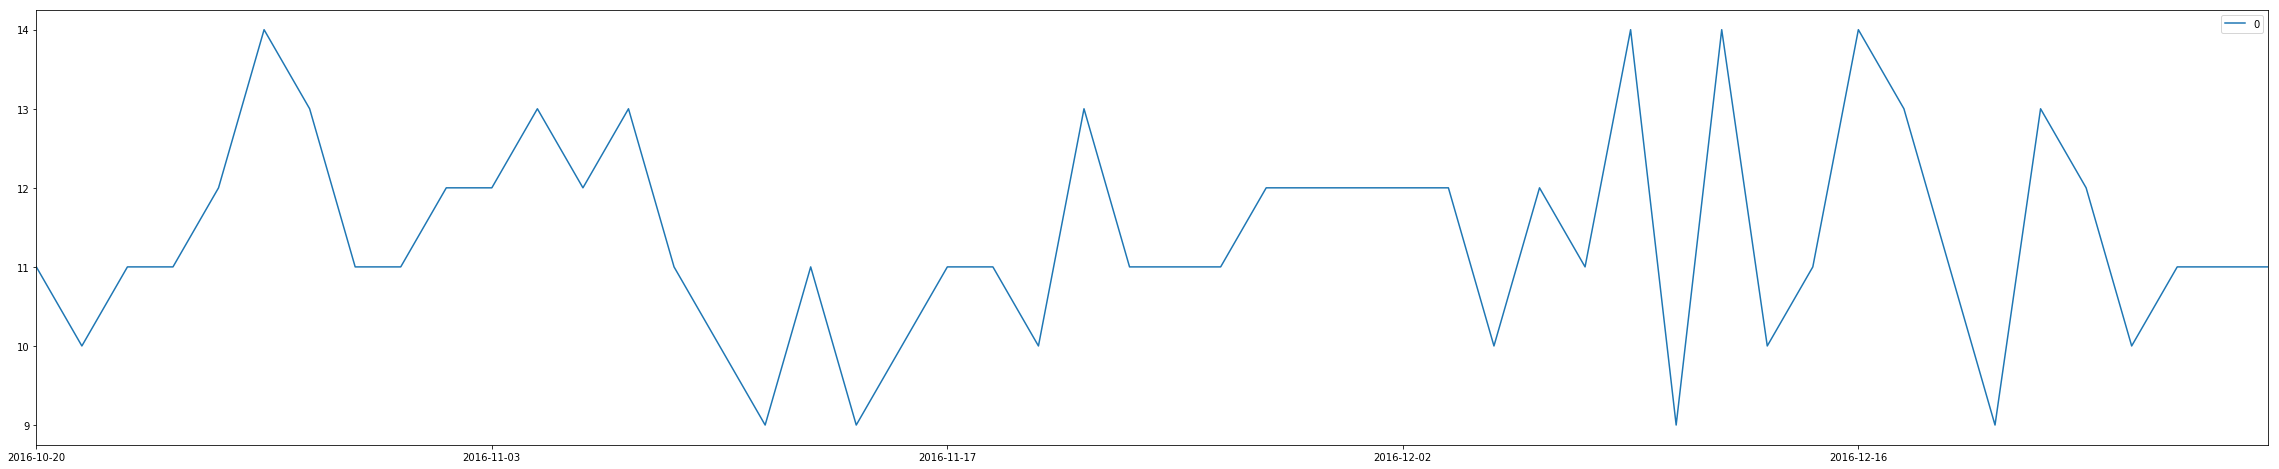

In [10]:
%matplotlib inline

from matplotlib import pyplot as plt
numberofclusters.plot(figsize=(40, 8))
plt.savefig("Graphs/DBHT_n_of_clusters_PMFG_exp_last50days_1000.pdf", bbox_inches='tight')

In [6]:
DBHT_exp_shrinkage_results = pickle.load(open("pickle/DBHT_exp_shrinkage_PMFG_theta_3_window_1000.p",'rb'))

In [9]:
clustering = DBHT_exp_shrinkage_results['DBHT_clusterings']
PMFG = DBHT_exp_shrinkage_results['PMFG']
sorteddates = sorted(clustering.keys(), key=lambda d: map(int, d.split('-')))

In [10]:
for t in sorteddates:
    clustering[t] = np.array(clustering[t])
    PMFG[t] = np.array(PMFG[t])

In [ ]:
clusters = {}
for t in sorteddates:
    clusters[t] =

In [32]:
def create_alluv_files(clustering, PMFG,folder):
    import os, errno
    try:
        os.makedirs("Graphs/"+folder)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
    sorteddates = sorted(clustering.keys(), key=lambda d: map(int, d.split('-')))
    for t in sorteddates:
        netf = open("Graphs/"+folder+"/"+t+".net", "wb")
        cluf = open("Graphs/"+folder+"/"+t+".clu", 'wb')
        netf.write('*Vertices {}\n'.format(PMFG[t].shape[0]))
        cluf.write('*Vertices {}\n'.format(PMFG[t].shape[0]))
        for i in range(PMFG[t].shape[0]):
            netf.write('{} "{}" 1.0\n'.format(i+1, i+1))
            cluf.write('{}\n'.format(int(clustering[t][i][0])))
        nofedges = np.count_nonzero(PMFG[t])/2
        netf.write('*Edges {}\n'.format(nofedges))
        for i in range(PMFG[t].shape[0]):
            for j in range(i, PMFG[t].shape[0]):
                if PMFG[t][i][j]!=0:
                    netf.write('{} {} {}\n'.format(i+1,j+1,PMFG[t][i][j]))
        netf.close()
        cluf.close()

In [19]:
create_alluv_files(clustering, PMFG, "PMFG_theta_3_window_1000")

IOError: [Errno 2] No such file or directory: 'Graphs/PMFG_theta_3_window_1000/1987-12-16.net'

In [292]:
ret.index[0].date().strftime("%Y-%m-%d")

'1984-01-03'

In [28]:
%matplotlib
from matplotlib import pyplot as plt
numberofclusters.plot(figsize=(20, 8))
plt.savefig("Graphs/DBHT_n_of_clusters_unshrunk.pdf", bbox_inches='tight')

Using matplotlib backend: Qt5Agg


In [ ]:
def plot_dendrogram(Zlist, date, savefile, ret_file='data/WRDS/SP500_ret_1985.csv',
                    rawdatafile='data/SP5001984.csv'):
    raw_data = pd.read_csv(rawdatafile, dtype={'PERMNO': str, 'TICKER':str})[['PERMNO', 'date', 'TICKER']]
    permnolist = pd.read_csv(ret_file).columns[1:].values
    tickerlist = []
    compareddate = datetime.strptime(date,'%Y-%m-%d').date().strftime('%m/%d/%Y')
    for permno in permnolist:
        tickerlist.append(raw_data.loc[(raw_data['PERMNO'] == permno)
                                       & (raw_data['date'] == compareddate)].values[0][2]
                          )
    eng = matlab.engine.start_matlab()
    eng.dendrogram(Zlist[date], 0,
                   'Orientation', 'left', 'Labels', tickerlist)
    eng.savefig(savefile, nargout=0)